In [1]:
import firedrake
import matplotlib.pyplot as plt
import icepack
import icepack.plot
from icepack.constants import ice_density as ρ_I, water_density as ρ_W
import numpy as np

# Firn modeling
Ice-sheet mass-balance estimates derived from surface altimetry observations require careful consideration of spatial variations in firn density. Firn models remain a large source of uncertainty within continental mass-balance estimates because of simplifying assumptions for densification physics, which often neglect the effects of horizontal strain on the integrated firn-air-content (FAC). We aim to include the effects of horizontal divergence and convergence on the densification of snow and firn in continental/catchment scale simulations of ice sheet mass change by building an extensible firn model that ingests multi-demensional strain regime information. The variables that define the state of the firn are the density, the vertical velocity of the firn, and the energy density. The densification of snow to ice is often defined by the material derivative, which in 1D can be written as

\begin{equation*} 
\frac{d\rho}{dt} = \frac{\partial\rho}{\partial t} + w \frac{\partial \rho}{\partial z}
\end{equation*}

The weak form of the densification equation can be written as

\begin{equation*} 
f_\rho = \int_\Omega \frac{d\rho}{dt} \phi d\Omega + \int_\Omega w \nabla \rho \phi d\Omega - \int_\Omega \frac{d\rho}{dt}\phi d\Omega
\end{equation*}

where we have integrated the density equation over the entire domain, and multiplied by the test function $\phi$. The vertical velocity $w$ can be defined by integrating the densification rate and similarly multiplying by the test function $\eta$.

\begin{equation*} 
w(z,t)=\int \frac{1}{\rho}\cdot \frac{d\rho}{dt}dz
\end{equation*} 
\begin{equation*} 
\frac{\partial w}{\partial z} = \frac{1}{\rho}\cdot \frac{d \rho}{dt}
\end{equation*} 

\begin{equation*} 
f_w = - \int_\Omega \rho \nabla w \psi d\Omega + \int_\Omega  \frac{d \rho}{dt}\psi d\Omega
\end{equation*} 

Future work will build in feedbacks with the thermal state of the firn. Following Arshwandan, we can also recast the shallow enthalpy equations into equations for the energy density. These can be broken up into energy density sources, and change as near surface heat conducts through the densifying firn. There are variables like the water/snow fraction that we might also be able to link to radiometric measurements that are regularly made with insar satellite constellations. The weak form for the energy density can be written as 

\begin{equation*} 
f_E = \int_\Omega w \rho \nabla E \psi d\Omega - \int_\Omega 
\left\{ \begin{array}{c}
K_i \\
K_0
\end{array}
\right\}
\nabla E \nabla \psi d\Omega - \int_\Omega \rho \frac{\partial E}{\partial t} \psi d\Omega
\end{equation*} 


Adding these terms we seek test functions that minimize the residual:

\begin{equation*} 
f= f_w + f_\rho + f_E
\end{equation*} 




# Geometry

We start by defining the geometry of the firn layer, which has a uniform depth of 200m (defined by the firn thickness) and is similar to the extruded inverval mesh that defines the hybrid model.

In [2]:
h_f=firedrake.Constant(200.0)
Lx, Ly = 50e3, 12e3
nx, ny = 1, 1
mesh2d = firedrake.RectangleMesh(nx, ny, Lx, Ly)
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

In [3]:
Q = firedrake.FunctionSpace(
    mesh, family='CG', degree=1,
    vfamily='DG', vdegree=10
)

In [4]:
ζ = firedrake.SpatialCoordinate(mesh)

# Surface condition

We start by defining the surface properties of densification. Importantly the surface density, the accumulation rate which defines the velocity condition at the surface and create the vertical velocity density and temperature objects. For these initial simulations temperature is assumed to be uniform with depth. Future work will evolve the temperature according to surface forcing and couple thermal feedbacks with the densification via the model chosen to describe $\frac{\partial \rho}{\partial t}$.

In [5]:
from icepack.constants import year as year
ρ_s = firedrake.Constant(360.0)
a = firedrake.Constant(.3)
w = firedrake.interpolate(firedrake.Constant(0.0),Q) 
ρ = firedrake.interpolate(ρ_s,Q)
T_avg = firedrake.Constant(273.15-15.)


In [6]:
model = icepack.models.FirnModel()
opts = {'default_solver_type': 'petsc',
        'default_solver_parameters': {
        'snes_type': 'newtontr',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
solver = icepack.solvers.FirnSolver(model)

In [7]:
final_time = 3.0
timestep = 1.0
num_steps = int(final_time / timestep)
dt = final_time / num_steps

for step in range(num_steps):
    ρ = solver.solve_density(dt,
                            firn_thickness=h_f,
                            density=ρ,
                            firn_velocity=w,
                            accumulation=a,
                            temperature=T_avg,
                            surface_density = ρ_s)
    w = solver.solve_velocity(dt,
                            firn_thickness=h_f,
                            density=ρ,
                            firn_velocity=w,
                            accumulation=a,
                            temperature=T_avg,
                            surface_density = ρ_s)
    

In [8]:
nz=10
xz = np.array([(0, 0, i) for i in np.arange(0,1.1,1.0/nz)])
density= np.array(ρ.at(xz, tolerance=1e-10))
density_vel = np.array(w.at(xz, tolerance=1e-10))

In [9]:
density

array([402.20877438, 402.20849547, 402.20825711, 402.20805145,
       402.20787188, 402.20771277, 402.20756928, 402.20743719,
       402.20731271, 402.20719244, 402.20707317])

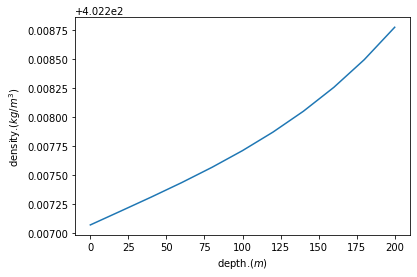

In [10]:
fig, ax = plt.subplots()
ax.plot(h_f-np.linspace(0,1.0,11)*h_f.dat.data,density)
ax.set_ylabel(r'density.($kg/m^3$)')
ax.set_xlabel(r'depth.($m$)')
plt.show()

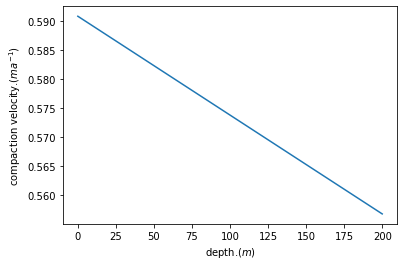

In [11]:
fig, ax = plt.subplots()
ax.plot(h_f-np.linspace(0,1.0,11)*h_f.dat.data,density_vel)
ax.set_ylabel(r'compaction velocity.($ma^{-1}$)')
ax.set_xlabel(r'depth.($m$)')
plt.show()